# Parte B. 
### Elaboração de um conjunto de scripts e funções em Python, NumPy, SciPy e Scikit-learn para realizar as tarefas de Aprendizagem Computacional e Avaliação

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from ReliefF import ReliefF #https://pypi.org/project/ReliefF/

# importar livraria que contem as funcoes das features
import featuresFunctions
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# ex 4
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

___

# 0. Utility functions

In [23]:
def get_classes(target):
    return np.unique(target)

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

### 0.1. Loading human activities dataset

In [3]:
def load_human_activities_dataset():
    loc = []

    for i in range (0,15):
        loc.append("FORTH_TRACE_DATASET-master/part" + str(i) + "/part" + str(i) + "dev2.csv")

    array = []
    for file in loc:
        df = pd.read_csv(file, sep=',', header=None)
        array.append(df.to_numpy())

    array = np.concatenate(array)
    #print(array.shape)

    return array

# hacti - HumanACTIvities
hacti_data = load_human_activities_dataset()
hacti_input = hacti_data[:, :11]
hacti_target = hacti_data[:, -1]

hacti_classes = get_classes(hacti_target)

dummy = hacti_data[:6]
dummy_input = dummy[:, :11]
dummy_target = dummy[:, -1]

hacti_classes

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.])

### 0.2. Loading Iris dataset

150 instances <br>
4 atributes:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

3 classes:
- Iris Setosa
- Iris Versicolour
- Iris Virginica

In [4]:
from sklearn.datasets import load_iris

iris_data = load_iris()

df = pd.DataFrame(iris_data.data, columns = iris_data.feature_names)
df['target'] = iris_data.target
print(df)
iris_df = df
iris_input = iris_data.data
iris_target = iris_data.target

iris_classes = get_classes(iris_target)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  

___

# 1. Data splitting e métricas de exactidão em machine learning
### 1.1. Usando o scikit-learn, desenvolva um conjunto de funções para **data splitting** usando dois cenários:

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

Divides x (input) and y (target) in: <br>
- x_train = x * test_perc   
- x_val = x * val_perc         
- x_test = x - x_train - x_val
- y_train = y * test_perc     
- y_val = y * val_perc
- y_test = y - y_train - y_val

In [5]:
def tt(x, y, test_perc):
    test_size = test_perc * 0.01
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)

    return x_train, x_test, y_train, y_test


def tvt(x, y, val_perc, test_perc):
    test_size = test_perc * 0.01
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)

    # 80 train, 20 test -> 60 train, 20 validation, 20 test
    val_size = test_perc * 0.01
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=1) # 0.25 x 0.8 = 0.2

    return x_train, x_val, x_test, y_train, y_val, y_test


### 1.1.2. K-fold data split

K-folds cross-validator. Returns k indexes of training and validating (min - 2. max - samples)

In [8]:
def k_fold_indexes(data_input, splits):
    kf = KFold(n_splits=splits)

    x_indexes_train=[]
    x_indexes_test=[]
    for i, (train_index, test_index) in enumerate(kf.split(data_input)):
        x_indexes_train.append(train_index)
        x_indexes_test.append(test_index)

        #print(train_index, test_index)

    return x_indexes_train, x_indexes_test
    

def k_fold_arrays(data_input, data_target, splits):
    input_train = []
    input_test = []
    target_train = []
    target_test = []

    train_indexes, test_indexes = k_fold_indexes(data_input, splits)
    
    # new train set according to indexes
    for i in train_indexes:
        input_train.append(data_input[i])
        target_train.append(data_target[i])

    # new test set according to indexes
    for j in test_indexes:
        input_test.append(data_input[j])
        target_test.append(data_target[j])

    # vstack to turn list of numpy arrays in simple numpy arrays
    #input_train = np.vstack(input_train)
    #input_test = np.vstack(input_test)
    # Input test set:  [array([[1, 2],
    #                 [3, 4]]), array([[5, 6]]), array([[7, 8]])]
    # Input test set:  [[1 2]
    #                 [3 4]
    #                 [5 6]
    #                 [7 8]]

    """
    print("--- ORIGINAL SET: ", data_input)
    print("Train indexes: ", train_indexes)
    print("Test indexes: ", test_indexes)
    print("--- TRAIN SET")
    print("Input train set: ", input_train)
    print("Target train set: ", target_train)
    print("---TEST SET")
    print("Input test set: ", input_test)
    print("Target test set: ", target_test)
    """

    return input_train, input_test, target_train, target_test

### TEST CODE
# K-FOLD

# dummy = human_activities_data[:6]
# dummy_input = dummy[:, :11]
# dummy_target = dummy[:, -1]


#dummy_train_indexes, dummy_test_indexes = k_fold_indexes(dummy_target, 5)
#print("---")

"""
x = np.array([[1,2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 10, 20])

kf_input_train, kf_input_test, kf_target_train, kf_target_test = k_fold_arrays(x, y, 3)

mean_score = 0.00
for i in range(len(kf_target_test)):
    input_train = kf_input_train[i]
    input_test = kf_input_test[i]
    target_train = kf_target_train[i]
    target_test = kf_target_test[i]

print(input_train)
print(input_test)
print(target_train)
print(target_test)
"""


#recall, precision, f1 = exact_methods(dummy_real, dummy_pred, 'macro')
#print(recall, precision, f1) # com average = 'micro' os resultados sao iguais


'\nx = np.array([[1,2], [3, 4], [5, 6], [7, 8]])\ny = np.array([1, 2, 10, 20])\n\nkf_input_train, kf_input_test, kf_target_train, kf_target_test = k_fold_arrays(x, y, 3)\n\nmean_score = 0.00\nfor i in range(len(kf_target_test)):\n    input_train = kf_input_train[i]\n    input_test = kf_input_test[i]\n    target_train = kf_target_train[i]\n    target_test = kf_target_test[i]\n\nprint(input_train)\nprint(input_test)\nprint(target_train)\nprint(target_test)\n'

### 1.2. Usando o scikit-learn, desenvolva um conjunto de funções para cálculo de **métricas de exactidação**, nomeadamente as seguintes:

### 1.1.2. Matriz de confusão
### 1.2.2. Recall
### 1.2.3. Precision
### 1.2.4. F1-score

In [6]:
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#from sklearn.metrics import recall_score, precision_score, f1_score

"""
def confusion(knn, target_test, target_pred):
    cm = confusion_matrix(target_test, target_pred)
    matrix = plot_confusion_matrix(knn, cm, target_test, cmap=plt.cm.Blues)
    matrix.ax_.set_title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.gcf().axes[0]
    plt.gcf().axes[1]
    return cm, plt

def plot_cm2222(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = SVC(random_state=0)
    clf.fit(X_train, y_train)
    SVC(random_state=0)
    predictions = clf.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()

    plt.show()

"""

def plot_cm(target_test, target_pred, classes):
    cm = confusion_matrix(target_test, target_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()

    plt.show()

def exact_methods(y_true, y_pred, av):
    '''
    av = micro
    av = macro
    av = binary
    av = samples
    av = weighted
    '''
    recall = recall_score(y_true, y_pred, average=av) # average=?
    precision = precision_score(y_true, y_pred, average=av)
    f1 = f1_score(y_true, y_pred, average=av)

    return recall, precision, f1


# 2. Experiências iniciais com um classificador simples, i.e., k-Nearest Neighbours (kNN)

### 2.1. Usando:
- as funções anteriores
- o algoritmo kNN
- o dataset Iris

avalie a capacidade de previsão do algoritmo neste dataset, com **k = 1** e restantes parâmetros por omissão (e.g., métrica de distância, etc.), e usando todo o conjunto de features, nos seguintes cenários:

### 2.1.1. Train-only, TT 70-30 e 10x10-fold cross-validation (10CV)

----- Train-only -----


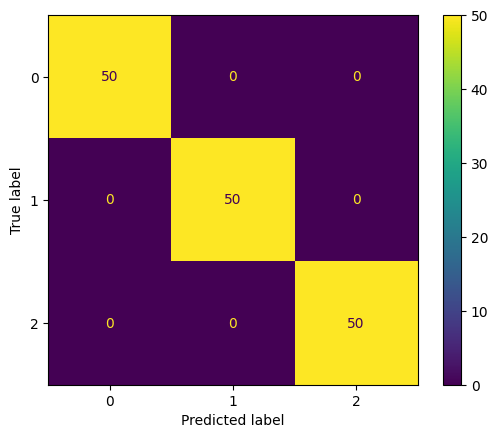

Recall:  1.0
Precision:  1.0
F1 score:  1.0 

----- TT 70-30 -----


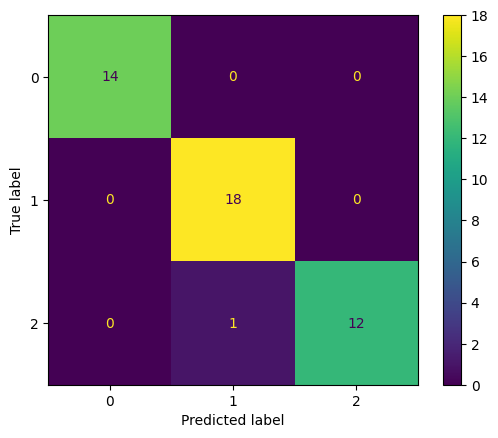

Recall:  0.9777777777777777
Precision:  0.9789473684210527
F1 score:  0.9776336336336338 

----- 10-FOLD CV -----
MEAN RECALL: 0.9600000000000002
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9788177339901478


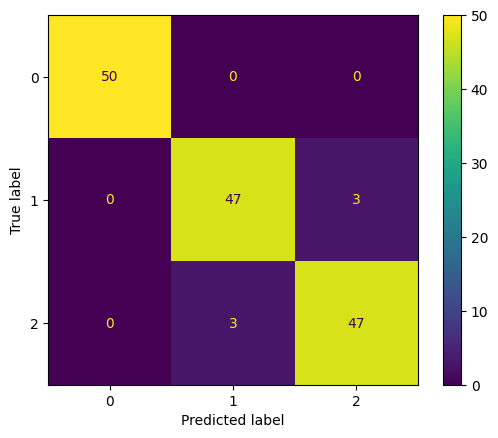

In [9]:
### TRAIN-ONLY
print("----- Train-only -----")

target_classes = iris_classes
input_train, target_train = iris_input, iris_target

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_pred = knn.predict(input_train)

recall, precision, f1 = exact_methods(target_train, target_pred, 'weighted')
cm = plot_cm(target_train, target_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")



### TT 70-30
print("----- TT 70-30 -----")

target_classes = iris_classes
input_train, input_test, target_train, target_test = tt(iris_input, iris_target, 30)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_pred = knn.predict(input_test)

recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
cm = plot_cm(target_test, target_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")



### 10-FOLD CV
print("----- 10-FOLD CV -----")

target_classes = iris_classes
fold = 10
kf_input_train, kf_input_test, kf_target_train, kf_target_test = k_fold_arrays(iris_input, iris_target, fold)

mean_recall = 0.00
mean_precision = 0.00
mean_f1 = 0.00
total_target_test = []
total_target_pred = []
for i in range(len(kf_target_test)):
    input_train = kf_input_train[i]
    input_test = kf_input_test[i]
    target_train = kf_target_train[i]
    target_test = kf_target_test[i]

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(input_train, target_train)
    target_pred = knn.predict(input_test)
    total_target_test.extend(target_test)
    total_target_pred.extend(target_pred)

    recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
    mean_recall += recall
    mean_precision += precision
    mean_f1 += f1


print("MEAN RECALL:", mean_recall/fold)
print("MEAN PRECISION:", mean_precision/fold)
print("MEAN F1 SCORE:", mean_f1/fold)
cm = plot_cm(total_target_test, total_target_pred, target_classes)






### 2.1.2. Train-only, TVT 40-30-30 e 10x10CV, fazendo variar k na gama {1, 3, 5, …, 15}.

----- TVT 40-30-30 -----
-- 1st iteration (with val set)
MEAN RECALL: 0.890625
MEAN PRECISION: 0.920301053113553
MEAN F1 SCORE: 0.8877378503452209 

----- 10-FOLD CV -----
-- k =  1
MEAN RECALL: 0.9600000000000002
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9788177339901478
-- k =  3
MEAN RECALL: 0.9466666666666669
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9714285714285715
-- k =  5
MEAN RECALL: 0.9333333333333333
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9634920634920636
-- k =  7
MEAN RECALL: 0.9333333333333333
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9637383689107827
-- k =  9
MEAN RECALL: 0.9333333333333333
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9634331186055324
-- k =  11
MEAN RECALL: 0.9333333333333336
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9641978509492122
-- k =  13
MEAN RECALL: 0.9400000000000002
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9681661049174661
-- k =  15
MEAN RECALL: 0.926666666666667
MEAN PRECISION: 1.0
MEAN F1 SCORE: 0.9605032696684239
ABSOLUTE MEAN RECALL: 0.9383333333333336
ABSOLUTE MEAN PRE

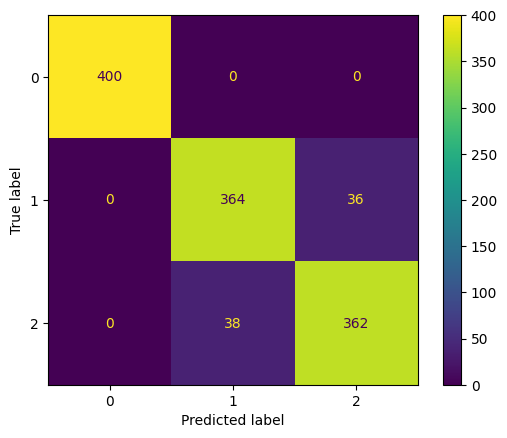

In [10]:
## TVT 40-30-30
print("----- TVT 40-30-30 -----")

target_classes = iris_classes
input_train, input_val, input_test, target_train, target_val, target_test = tvt(iris_input, iris_target, 57.1428, 30) # 3 simples -> 70-100; 40-x; x = 40*100/70 = 57.1428 

k_neigh = [1, 3, 5, 7, 9, 11, 13, 15]

mean_recall = 0.00
mean_precision = 0.00
mean_f1 = 0.00

print("-- 1st iteration (with val set)")
for k in k_neigh:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(input_train, target_train)
    target_val_pred = knn.predict(input_val)

    recall, precision, f1 = exact_methods(target_val, target_val_pred, 'weighted')
    #cm = plot_cm(target_val, target_val_pred, target_classes)

    mean_recall += recall
    mean_precision += precision
    mean_f1 += f1

print("MEAN RECALL:", mean_recall/len(k_neigh))
print("MEAN PRECISION:", mean_precision/len(k_neigh))
print("MEAN F1 SCORE:", mean_f1/len(k_neigh), "\n")


### 10-FOLD CV
print("----- 10-FOLD CV -----")

target_classes = iris_classes
fold = 10
kf_input_train, kf_input_test, kf_target_train, kf_target_test = k_fold_arrays(iris_input, iris_target, fold)


absolute_mean_recall = 0.00
absolute_mean_precision = 0.00
absolute_mean_f1 = 0.00

absolute_total_target_test = []
absolute_total_target_pred = []

for k in k_neigh:
    mean_recall = 0.00
    mean_precision = 0.00
    mean_f1 = 0.00

    print("-- k = ", k)
    total_target_test = []
    total_target_pred = []
    for i in range(len(kf_target_test)):
        input_train = kf_input_train[i]
        input_test = kf_input_test[i]
        target_train = kf_target_train[i]
        target_test = kf_target_test[i]

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(input_train, target_train)
        target_pred = knn.predict(input_test)
        total_target_test.extend(target_test)
        total_target_pred.extend(target_pred)

        recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
        mean_recall += recall
        mean_precision += precision
        mean_f1 += f1


    print("MEAN RECALL:", mean_recall/fold)
    print("MEAN PRECISION:", mean_precision/fold)
    print("MEAN F1 SCORE:", mean_f1/fold)

    absolute_mean_recall += mean_recall/fold
    absolute_mean_precision += mean_precision/fold
    absolute_mean_f1 += mean_f1/fold
    absolute_total_target_test.extend(total_target_test)
    absolute_total_target_pred.extend(total_target_pred)


print("ABSOLUTE MEAN RECALL:", absolute_mean_recall/len(k_neigh))
print("ABSOLUTE MEAN PRECISION:", absolute_mean_precision/len(k_neigh))
print("ABSOLUTE MEAN F1 SCORE:", absolute_mean_f1/len(k_neigh))
cm = plot_cm(absolute_total_target_test, absolute_total_target_pred, target_classes)



In [ ]:
"""
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = tt(X, y, 0.5)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train) #train
y_pred = knn.predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
acc = knn.score(X_test, y_test) #test

from sklearn.model_selection import cross_val_score

knn_cv = KNeighborsClassifier(n_neighbors=6)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, y, cv=10)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

neighbours = np.linspace(1, 15, 8)

for n in neighbours:
    knn = KNeighborsClassifier(n_neighbors=int(n))
    knn.fit(X, y)

neigh = np.linspace(1, 15, 8)
print(neigh)
"""

In [ ]:
"""
# TT, TVT e nCV

#def tt(X, y, test_size):

def cross_validation(train_X, train_y, num_folds=10, k=1):
    dataset = list()
    dataset_split = list()
    val_acc = list()
    
    for i in range(len(train_X)):
        data = np.append(train_X[i],train_y[i])
        dataset.append(data)
    
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / num_folds)
    
    for i in range(num_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
        
    for folds in dataset_split:
        train_set= folds
        train_set = np.array(train_set)
        test_set = list()
        for row in folds:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        test_set = np.array(test_set)
        train_x = train_set[:, :-1]
        train_y = train_set[:,-1]
        test_x = test_set[:, :-1]
        predicted = predict(train_x,train_y, test_x, k)
        actual = [row[-1] for row in fold]
        accuracy = compute_accuracy(actual, predicted)
        val_acc.append(accuracy)
        
    val_acc_var = statistics.variance(val_acc)
    vall_acc = sum(val_acc)/len(val_acc)

    return vall_acc, val_acc_var

"""

### 2.1.3. Analise os resultados em termos de **bias-variance** e **underfitting-overfitting**

Thinking about a dartboard:
- Low bias,  low variance  : population is **close** to center; individuals are **close** to each other
- Low bias,  high variance : population is **close** to center; individuals are **far** from each other
- High bias, low variance  : population is **far** from the center; individuals are **close** to each other
- High bias, high variance : population is **far** from the center; individuals are **far** from each other
    

**Underfitting**: model does not predict the data very well <br>
**Overfitting**: model predicts the data too well <br>

Our model:
- Low bias: The predicted results are almost always right
- Low variance: The results are close to each other, as almost all of them are in the same position
- Overfitted: there are few classes and features for classification. Classification is very easy.



### 2.2. Repita a experiência anterior usando o algoritmo ReliefF para obter o ranking de features e seleccionar o modelo ideal (em termos de parâmetros e features a utilizar)

### 2.2.1. Utilize a métrica F1-score como critério óptimo para a escolha de features e parâmetros a utilizar

In [11]:
### TT 70-30
input_data, target_data = iris_input, iris_target

n_neig = 1
n_feat = 2
fs = ReliefF(n_neighbors=n_neig, n_features_to_keep=n_feat)
input_data = fs.fit_transform(input_data, target_data)

# print("--------------")
# print("(No. of tuples, No. of Columns before ReliefF) : "+str(input_data.shape)+
      # "\n(No. of tuples , No. of Columns after ReliefF) : "+str(input_train.shape))

print(fs.top_features)
print(fs.feature_scores)


[3 0 2 1]
[-34. -56. -50. -12.]


### 2.2.2. Visualize o “gráfico do cotovelo” relativo ao desempenho do modelo (no conjunto de validação) à medida que se vão adicionando features

Distortion increases as we consider more features

[3 0 2 1]
4
Feature  3


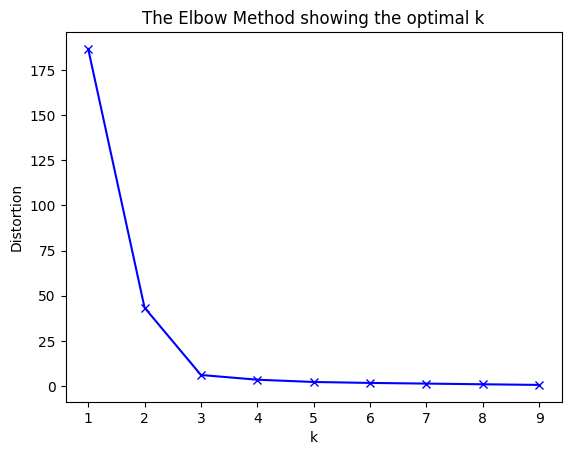

Feature  0


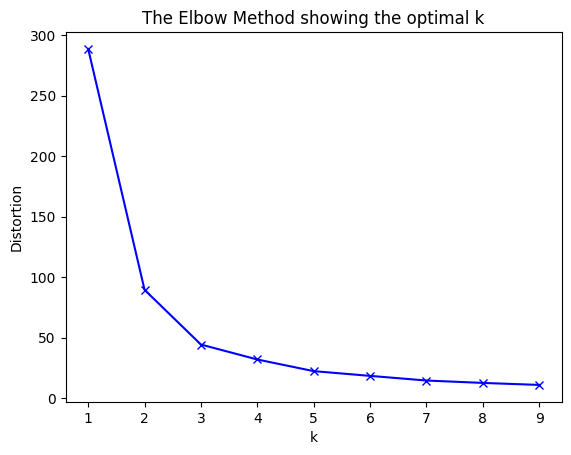

Feature  2


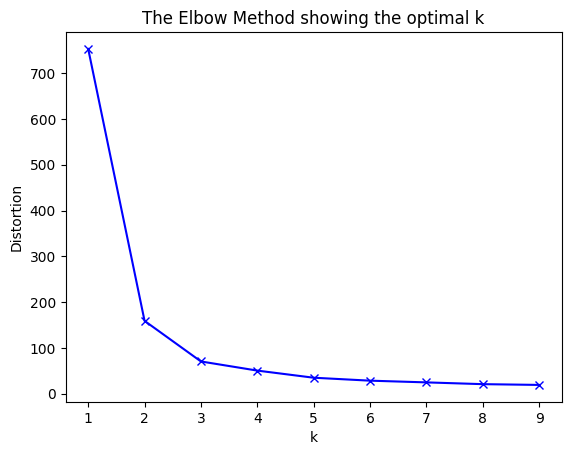

Feature  1


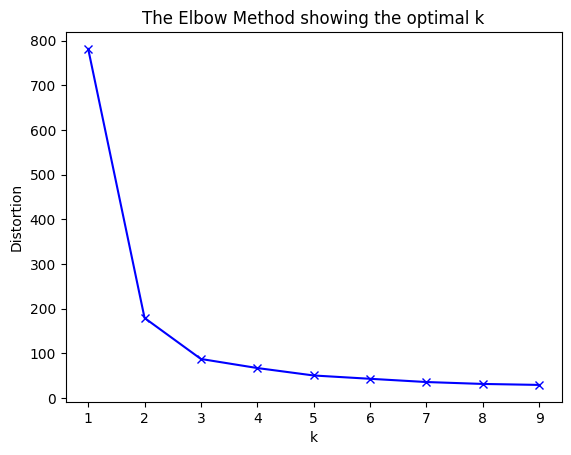

In [12]:
input_data, target_data = iris_input, iris_target

n_neig = 1
n_feat = 2

fs = ReliefF(n_neighbors=n_neig, n_features_to_keep=n_feat)
test_data = fs.fit_transform(input_data, target_data)

top_features = fs.top_features
print(top_features)
total_features = len(input_data[0])
print(total_features)
for i in range(1, total_features+1):
    print("Feature ", top_features[i-1])
    # create indexes
    indexes = top_features[:i]
    
    input_data = iris_input[:, indexes]
    
    df = pd.DataFrame(input_data)
    df['target'] = target_data
    
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    plt.figure()
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()


#df = pd.DataFrame(iris_data.data, columns = iris_data.feature_names)



In [ ]:
"""

## TVT 40-30-30
print("----- TVT 40-30-30 -----")

target_classes = iris_classes
input_train, input_val, input_test, target_train, target_val, target_test = tvt(iris_input, iris_target, 57.1428, 30) # 3 simples -> 70-100; 40-x; x = 40*100/70 = 57.1428 

k_neigh = [1, 3, 5, 7, 9, 11, 13, 15]

mean_recall = 0.00
mean_precision = 0.00
mean_f1 = 0.00

print("-- 1st iteration (with val set)")
for k in k_neigh:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(input_train, target_train)
    target_val_pred = knn.predict(input_val)

    recall, precision, f1 = exact_methods(target_val, target_val_pred, 'weighted')
    #cm = plot_cm(target_val, target_val_pred, target_classes)

    mean_recall += recall
    mean_precision += precision
    mean_f1 += f1

print("MEAN RECALL:", mean_recall/len(k_neigh))
print("MEAN PRECISION:", mean_precision/len(k_neigh))
print("MEAN F1 SCORE:", mean_f1/len(k_neigh), "\n")



neighbours = 5
x_relief = relief(X, y, neighbours, 10) # TODO qual o numero de features que se quer
# TODO tem que se alterar o algoritmo de relief?
print(x_relief.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(x_relief, y, test_size=0.3, random_state=1)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train) #train
y_pred = knn.predict(X_test)

f1_score(y_pred, y_test, average=None)

"""

error_rate = []# Will take some time
for i in range(1, X_train.shape[1]+1):
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,X_train.shape[1]+1),error_rate,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
### TRAIN-ONLY
print("----- Train-only -----")

target_classes = iris_classes
input_train, target_train = iris_input, iris_target

## 2.3 ------

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_pred = knn.predict(input_train)

recall, precision, f1 = exact_methods(target_train, target_pred, 'weighted')
cm = plot_cm(target_train, target_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")



### TT 70-30
print("----- TT 70-30 -----")

target_classes = iris_classes
input_train, input_test, target_train, target_test = tt(iris_input, iris_target, 30)

## 2.3 ------

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(input_train, target_train)
target_pred = knn.predict(input_test)

recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
cm = plot_cm(target_test, target_pred, target_classes)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1 score: ", f1, "\n")



### 10-FOLD CV
print("----- 10-FOLD CV -----")

target_classes = iris_classes
fold = 10
kf_input_train, kf_input_test, kf_target_train, kf_target_test = k_fold_arrays(iris_input, iris_target, fold)

## 2.3 ------

mean_recall = 0.00
mean_precision = 0.00
mean_f1 = 0.00
total_target_test = []
total_target_pred = []
for i in range(len(kf_target_test)):
    input_train = kf_input_train[i]
    input_test = kf_input_test[i]
    target_train = kf_target_train[i]
    target_test = kf_target_test[i]

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(input_train, target_train)
    target_pred = knn.predict(input_test)
    total_target_test.extend(target_test)
    total_target_pred.extend(target_pred)

    recall, precision, f1 = exact_methods(target_test, target_pred, 'weighted')
    mean_recall += recall
    mean_precision += precision
    mean_f1 += f1


print("MEAN RECALL:", mean_recall/fold)
print("MEAN PRECISION:", mean_precision/fold)
print("MEAN F1 SCORE:", mean_f1/fold)
cm = plot_cm(total_target_test, total_target_pred, target_classes)






# 3. Análise ao *dataset* original

In [ ]:
loc = []

for i in range (0,15):
    loc.append("FORTH_TRACE_DATASET-master/part" + str(i) + "/part" + str(i) + "dev2.csv")

array = []
for file in loc:
    df = pd.read_csv(file, sep=',', header=None)
    array.append(df.to_numpy())

array = np.concatenate(array)
print(array.shape)

___

# 4. Repita o ponto 2 no dataset de actividades humanos utilizado neste trabalho, usando data splitting **TVT** (apenas TVT; CV não é para fazer), uma **rede neuronal feedforward** (MLP) com **3 camadas**, **número variável de neurónios na camada escondida**, função de **activação logística** em todos os neurónios, **batch learning** e as features seleccionadas nas alíneas anteriores:

### 4.1. Com velocidade de aprendizagem fixo

In [ ]:
input_data, target_data = iris_input, iris_target

input_train, input_val, input_test, target_train, target_val, target_test = tvt(input_data, target_data, 30, 30)

feedforward = MLPClassifier(learning_rate='adaptive', activation='logistic', batch_size='lbfgs', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, ), random_state=1)

feedforward.fit(input_train, target_train)

print(target_test)
target_pred = feedforward.predict(input_test)
print(target_pred)

recall, precision, f1 = exact_methods(target_test, target_pred, None)

### 5. Desenvolva de raiz a sua própria rede neuronal (de acordo com o especificado na alínea 4), usando para treino o algoritmo de retropropagação do erro.

In [56]:
class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(len(self.input),4) 
        self.weights2   = np.random.rand(len(self.input),4)      
        self.weights3   = np.random.rand(4,1)             
        self.y          = y
        self.output     = np.zeros(y.shape)

    def feedforward(self): #sigmoid/logistic
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2))
        self.output = sigmoid(np.dot(self.layer2, self.weights3))

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1)))

        # update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2


input_data, target_data = hacti_input, hacti_target
nn = NeuralNetwork(input_data, target_data)

#print("\nLEN: ", len(input_data[0]))
#print("\nW1: ", nn.weights1)
#print("\nW2: ", nn.weights2)
#print("\nW3: ", nn.weights3)
print("\nOutput: ", nn.input)

ola = nn.feedforward()


Output:  [[2.0000e+00 3.0317e+00 9.0450e+00 ... 6.8849e-01 1.2654e+00 6.3629e+01]
 [2.0000e+00 2.9591e+00 9.0436e+00 ... 6.8849e-01 1.2741e+00 8.3160e+01]
 [2.0000e+00 2.9465e+00 9.0545e+00 ... 6.7857e-01 1.2675e+00 1.0269e+02]
 ...
 [2.0000e+00 1.7283e+00 9.5641e+00 ... 9.2857e-01 1.3531e+00 1.0420e+06]
 [2.0000e+00 1.7285e+00 9.5646e+00 ... 9.0675e-01 1.3377e+00 1.0420e+06]
 [2.0000e+00 1.6802e+00 9.4907e+00 ... 8.6310e-01 1.3180e+00 1.0420e+06]]


ValueError: shapes (781822,11) and (781822,4) not aligned: 11 (dim 1) != 781822 (dim 0)